In [1]:
import sys,os
folder_name="march_madness"
BASE_DIR=os.path.abspath(".").split(folder_name)[0]+folder_name
DATA_ROOT=os.path.join(BASE_DIR,"data")
#todo setup shared utilities folder
sys.path.insert(0, DATA_ROOT)

In [2]:
import pandas as pd
pd.options.display.max_rows=5#So we don't have to always write head
pd.options.display.max_columns=999
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import featuretools as ft

In [3]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\MatteoHoch\\Documents\\projects\\freelance\\upwork\\feature_labs\\march_madness\\notebooks\\utils.py'>

In [4]:
matchups_es=utils.load_entityset()

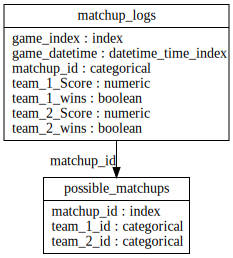

In [5]:
matchups_es.plot()

In [6]:
matchups_es["matchup_logs"]["team_1_wins"].interesting_values = [False, True]
matchups_es["matchup_logs"]["team_2_wins"].interesting_values = [False, True]

In [73]:
#I wrote these 3 functions quickly and they are a little sloppy. The only difference between them is the line with label time assignment
def make_cutoff_labels(es, training_window, cutoff_time,
                prediction_window):

    prediction_window_end = cutoff_time + prediction_window
    t_start = cutoff_time - training_window

    matchup_logs = es["matchup_logs"].df
    
    time_index="game_datetime"
    training_data = matchup_logs[(matchup_logs[time_index] <= cutoff_time) & (matchup_logs[time_index] > t_start)]
    prediction_data = matchup_logs[(matchup_logs[time_index] > cutoff_time) & (matchup_logs[time_index] < prediction_window_end)]
    
    matchup_ids_in_training = training_data['matchup_id'].unique()
    valid_pred_data = prediction_data[prediction_data['matchup_id'].isin(matchup_ids_in_training)]
    extra_cols=['team_1_wins']
    labels = valid_pred_data[["game_index","game_datetime",]+extra_cols]
    labels["time"] = cutoff_time
    del labels['game_datetime']
    labels = labels[["game_index", "time",]+extra_cols]

    return labels.reset_index(drop=True)
def make_day_of_labels(es, training_window, cutoff_time,
                prediction_window):

    prediction_window_end = cutoff_time + prediction_window
    t_start = cutoff_time - training_window

    matchup_logs = es["matchup_logs"].df
    
    time_index="game_datetime"
    training_data = matchup_logs[(matchup_logs[time_index] <= cutoff_time) & (matchup_logs[time_index] > t_start)]
    prediction_data = matchup_logs[(matchup_logs[time_index] > cutoff_time) & (matchup_logs[time_index] < prediction_window_end)]
    
    matchup_ids_in_training = training_data['matchup_id'].unique()
    valid_pred_data = prediction_data[prediction_data['matchup_id'].isin(matchup_ids_in_training)]
    extra_cols=['team_1_wins']
    labels = valid_pred_data[["game_index","game_datetime",]+extra_cols]
    labels["time"] = labels['game_datetime']
    del labels['game_datetime']
    labels = labels[["game_index", "time",]+extra_cols]

    return labels.reset_index(drop=True)
def make_day_before_labels(es, training_window, cutoff_time,
                prediction_window):

    prediction_window_end = cutoff_time + prediction_window
    t_start = cutoff_time - training_window

    matchup_logs = es["matchup_logs"].df
    
    time_index="game_datetime"
    training_data = matchup_logs[(matchup_logs[time_index] <= cutoff_time) & (matchup_logs[time_index] > t_start)]
    prediction_data = matchup_logs[(matchup_logs[time_index] > cutoff_time) & (matchup_logs[time_index] < prediction_window_end)]
    
    matchup_ids_in_training = training_data['matchup_id'].unique()
    valid_pred_data = prediction_data[prediction_data['matchup_id'].isin(matchup_ids_in_training)]
    extra_cols=['team_1_wins']
    labels = valid_pred_data[["game_index","game_datetime",]+extra_cols]
    labels["time"] = labels['game_datetime']-pd.Timedelta("1 day")
    del labels['game_datetime']
    labels = labels[["game_index", "time",]+extra_cols]

    return labels.reset_index(drop=True)

Below I've highlighted a matchup_id with multiple occurrences in a short time window

In [35]:
matchups_es['matchup_logs'].df[matchups_es['matchup_logs'].df['matchup_id']=='1211_1388'].iloc[:3]

,game_index,game_datetime,matchup_id,team_1_Score,team_1_wins,team_2_Score,team_2_wins
2003_74_1211_1388,2003_74_1211_1388,2003-01-17,1211_1388,56,True,53,False
2003_101_1211_1388,2003_101_1211_1388,2003-02-13,1211_1388,73,True,49,False
2003_125_1211_1388,2003_125_1211_1388,2003-03-09,1211_1388,73,True,52,False


In [50]:
#We will try 3 different label cutoffs
cutoff_labels = make_cutoff_labels(matchups_es, 
            cutoff_time = pd.Timestamp('March 3, 2003'),
                                prediction_window = ft.Timedelta("12 weeks"),
                                training_window = ft.Timedelta("12 weeks")
           )

day_before_labels=make_day_before_labels(matchups_es, 
            cutoff_time = pd.Timestamp('March 3, 2003'),
                                prediction_window = ft.Timedelta("12 weeks"),
                                training_window = ft.Timedelta("12 weeks")
           )

day_of_labels=make_day_of_labels(matchups_es, 
            cutoff_time = pd.Timestamp('March 3, 2003'),
                                prediction_window = ft.Timedelta("12 weeks"),
                                training_window = ft.Timedelta("12 weeks")
           )

In [74]:
#the label times show 1 game should be predicted using various cutoff times for the game on 2003-03-09
for label_times in [cutoff_labels,day_before_labels,day_of_labels]:
    print("time cutoff")
    display(label_times[label_times['game_index'].str.contains('1211_1388')])
    
    feature_matrix, features = ft.dfs(target_entity="matchup_logs", 
                                      cutoff_time=label_times,
                                      training_window=ft.Timedelta("12 weeks"), # same as above
                                      entityset=matchups_es,
                                      cutoff_time_in_index=True,
                                      instance_ids=["game_index","matchup_id "]

                                     )
    # encode categorical values
    fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                      features)

    print("Printing game of interest features")
    display(fm_encoded.loc[['2003_125_1211_1388']][['possible_matchups.COUNT(matchup_logs)','possible_matchups.MEAN(matchup_logs.team_2_Score)']])
    
    print("\n\n")

time cutoff


,game_index,time,team_1_wins
211,2003_125_1211_1388,2003-03-03,True


Printing game of interest features


,,possible_matchups.COUNT(matchup_logs),possible_matchups.MEAN(matchup_logs.team_2_Score)
game_index,time,,
2003_125_1211_1388,2003-03-03,0,NaN





time cutoff


,game_index,time,team_1_wins
211,2003_125_1211_1388,2003-03-08,True


Printing game of interest features


,,possible_matchups.COUNT(matchup_logs),possible_matchups.MEAN(matchup_logs.team_2_Score)
game_index,time,,
2003_125_1211_1388,2003-03-08,0,NaN





time cutoff


,game_index,time,team_1_wins
211,2003_125_1211_1388,2003-03-09,True


Printing game of interest features


,,possible_matchups.COUNT(matchup_logs),possible_matchups.MEAN(matchup_logs.team_2_Score)
game_index,time,,
2003_125_1211_1388,2003-03-09,3,51.333333


The game was played on 2003-03-09 and there were 2 games played by these teams in the listed time window. See below for reference
  


In [75]:
matchups_es['matchup_logs'].df[matchups_es['matchup_logs'].df['matchup_id']=='1211_1388'].iloc[:3]

,game_index,game_datetime,matchup_id,team_1_Score,team_1_wins,team_2_Score,team_2_wins
2003_74_1211_1388,2003_74_1211_1388,2003-01-17,1211_1388,56,True,53,False
2003_101_1211_1388,2003_101_1211_1388,2003-02-13,1211_1388,73,True,49,False
2003_125_1211_1388,2003_125_1211_1388,2003-03-09,1211_1388,73,True,52,False


The various cutoff times should grab the two games these teams have played before for the first two times labels I tried. And then all 3 with the last one. This output jumps from 0 to 3 games included and has no matchup_count of 2 like I would expect for some time cutoffs.